In [188]:
# !pip install "gymnasium==0.29.1" -q
# !pip install myosuite -q
# !pip install -q tqdm
# !pip install -q scipy
# !pip install -q matplotlib
# !pip install -q pandas
# !pip install -q skvideo
# !pip install osqp -q


In [221]:
from IPython.display import HTML
from myosuite.logger.grouped_datasets import Trace
import matplotlib.pyplot as plt
from base64 import b64encode
import scipy.sparse as spa
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import math
from myosuite.simhive.myo_sim.test_sims import TestSims as loader
import numpy as np
import skvideo.io
import mujoco
import osqp
import os

import logging

# Show everything
logging.getLogger().setLevel(logging.DEBUG)

In [222]:
# # Download the model from Myolab
# """
# Model is from Myolab and not MyoHub. Thus can't use Test Sim loader. Ask community if I have to move them
# """
# !git clone https://github.com/MyoHub/myosuite /Users/siddheshkanawade/Desktop/Siddhesh/Projects/myochallenge-2025/myosuite

# # Clone into a specific folder
# !git clone https://github.com/MyoHub/myo_sim.git /Users/siddheshkanawade/Desktop/Siddhesh/Projects/myochallenge-2025/myosuite/myosuite/simhive/myo_sim
# %cd ./content/myosuite/myosuite/simhive/myo_sim
# !git checkout 33f3ded946f55adbdcf963c99999587aadaf975f

In [233]:
# model_path = "/Users/siddheshkanawade/Desktop/Siddhesh/Projects/myochallenge-2025/myosuite/myosuite/simhive/myo_sim/arm/myoarm.xml"
# model_path = "/Users/siddheshkanawade/Desktop/Siddhesh/Projects/myochallenge-2025/myosuite/myosuite/simhive/myo_sim/hand/myohand.xml"
model_path = "/Users/siddheshkanawade/Desktop/Siddhesh/Projects/myochallenge-2025/myosuite/myosuite/simhive/myo_sim/elbow/myoelbow_1dof6muscles.xml"


# Utils

In [234]:
# Load model - xml
def get_sim(model_path):
  return mujoco.MjModel.from_xml_path(model_path)

# Load model - loader
def get_sim_from_loader(model_name):
  return loader.get_sim(None, model_name)

def show_video(video_path, video_width = 400):
    """
    Display a video within the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")

def solve_qp(P, q, lb, ub, x0, reg=1e-8, cond_thresh=1e10):
    """
    Solve a strictly convex box-QP: 0.5 x^T P x + q^T x s.t. lb <= x <= ub
    """
    # Regularize to avoid near-singularities - tikhonov regularization
    if P.ndim == 2:
        P = P + reg * np.eye(P.shape[0])
    P = spa.csc_matrix(P)

    A = spa.eye(q.shape[0], format="csc")  # box constraints
    m = osqp.OSQP()
    m.setup(
        P=P, q=q, A=A, l=lb, u=ub, verbose=False,
        max_iter=20000, eps_abs=1e-8, eps_rel=1e-8,
        polish=True, scaling=True  # enable scaling for stability
    )
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def map_error_to_joint(error, model):
    jnt_error_map = {} # jnt_name -> error
    for j in range(model.njnt):
        jnt_name = model.joint(j).name
        qpos_addr = model.jnt_qposadr[j]   # starting index in qpos
        jtype = model.jnt_type[j]
        
        if jtype == 0:   # free
          dim = 7
        elif jtype == 1: # ball
            dim = 4
        else:            # hinge/slide
            dim = 1
        
        jnt_error_map[jnt_name] = error[qpos_addr:qpos_addr+dim][0]
    return jnt_error_map

def plot_sigmoid_x(x):
    # Plot horizontal line at y = 0.5
    plt.axhline(y=0.5, color='black', linestyle='--')

    # Plot the sigmoid function
    plt.plot(x, 1 / (1 + np.exp(-x)), label='Sigmoid function')
    
    # Plot approximated sigmoid function
    plt.plot(x, 1.875 * x - 0.4375, label='Approximated sigmoid function')

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sigmoid function and its approximation')
    plt.legend()
    plt.show()


def plot_qforce(qforce, model, not_present_joints=None):
    """
    Plot qforce as time series.
    """
    steps = qforce.shape[0]
    time = range(steps)

    joint_names = []
    if not_present_joints:
        # Only plot joints not present in the model
        joint_names = [model.joint(i).name for i in not_present_joints]
        qforce = qforce[:, not_present_joints]
    else:
        joint_names = [model.joint(i).name for i in range(model.njnt)]

    plt.figure(figsize=(12, 6))
    for i, name in enumerate(joint_names):
        plt.plot(time, qforce[:, i], label=name)

    plt.xlabel("Timestep")
    title = f"Q-force for all joints" if not_present_joints is None else f"Q-force for joints not present in model"
    plt.ylabel(f"{title}")
    plt.title("Joint Forces Over Time")

    # Legend below the plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=5,   # 5 joint names per row
        frameon=False
    )

    plt.tight_layout()
    # plt.show()
    filename = f"qforce_all_joints.png" if not_present_joints is None else f"qforce_not_present_joints.png"
    plt.savefig(f"{filename}")



def plot_qxxx(qxxx, joint_names, labels):
    """
    Plot generalized variables to be compared.
    qxxx[:,0,-1] = time axis
    qxxx[:,1:,n] = n-th sequence
    qxxx[:,1:,-1] = reference sequence
    """
    fig, axs = plt.subplots(4, 6, figsize=(12, 8))
    axs = axs.flatten()
    line_objects = []
    linestyle = ['-'] * qxxx.shape[2]
    linestyle[-1] = '--'
    for j in range(1, len(joint_names)+1):
        ax = axs[j-1]
        for i in range(qxxx.shape[2]):
            line, = ax.plot(qxxx[:, 0, -1], qxxx[:, j, i], linestyle[i])
            if j == 1: # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_xlim([qxxx[:, 0].min(), qxxx[:, 0].max()])
        ax.set_ylim([qxxx[:, 1:, :].min(), qxxx[:, 1:, :].max()])
        ax.set_title(joint_names[j-1])
    legend_ax = axs[len(joint_names)] # create legend in the 24th subplot area
    legend_ax.axis('off')
    legend_ax.legend(line_objects, labels, loc='center')
    plt.tight_layout()
    plt.show()

def plot_qxxx(qxxx, joint_names, labels, lw=20):
    """
    Plot joint variables to be compared.
    qxxx[:,0,-1] = time axis
    qxxx[:,1:,n] = n-th sequence
    """
    n_joints = len(joint_names)
    ncols = 6
    nrows = math.ceil((n_joints + 1) / ncols)  # +1 for legend subplot

    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axs = axs.flatten()

    line_objects = []
    linestyle = ['-'] * qxxx.shape[2]
    linestyle[-1] = '--'

    for j in range(1, n_joints+1):
        ax = axs[j-1]
        for i in range(qxxx.shape[2]):
            line, = ax.plot(
                qxxx[:, 0, -1],
                qxxx[:, j, i],
                linestyle[i],
                linewidth=lw
            )
            if j == 1:  # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_xlim([qxxx[:, 0].min(), qxxx[:, 0].max()])
        ax.set_ylim([qxxx[:, 1:, :].min(), qxxx[:, 1:, :].max()])
        ax.set_title(joint_names[j-1])

    # legend in last subplot
    legend_ax = axs[n_joints]
    legend_ax.axis('off')
    legend_ax.legend(line_objects, labels, loc='center')

    plt.tight_layout()
    plt.show()

# Preprocess Trajectory

In [235]:
inverse_name_map = {
    "Abs_t2": "Abs_t2",
    "Abs_t1": "Abs_t1",
    "Abs_r3": "Abs_r3",
    "pro_sup": "pro_sup",
    "deviation": "deviation",
    # Spine
    "L5_S1_Flex_Ext": "flex_extension",
    "L5_S1_Lat_Bending": "lat_bending",
    "L5_S1_axial_rotation": "axial_rotation",
    "L4_L5_Flex_Ext": "L4_L5_FE",
    "L4_L5_Lat_Bending": "L4_L5_LB",
    "L4_L5_axial_rotation": "L4_L5_AR",
    "L3_L4_Flex_Ext": "L3_L4_FE",
    "L3_L4_Lat_Bending": "L3_L4_LB",
    "L3_L4_axial_rotation": "L3_L4_AR",
    "L2_L3_Flex_Ext": "L2_L3_FE",
    "L2_L3_Lat_Bending": "L2_L3_LB",
    "L2_L3_axial_rotation": "L2_L3_AR",
    "L1_L2_Flex_Ext": "L1_L2_FE",
    "L1_L2_Lat_Bending": "L1_L2_LB",
    "L1_L2_axial_rotation": "L1_L2_AR",
    # # Clavicle / scapula
    "sternoclavicular_r2_r": "sternoclavicular_r2",
    "sternoclavicular_r3_r": "sternoclavicular_r3",
    "unrotscap_r3_r": "unrotscap_r3",
    "unrotscap_r2_r": "unrotscap_r2",
    "acromioclavicular_r2_r": "acromioclavicular_r2",
    "acromioclavicular_r3_r": "acromioclavicular_r3",
    "acromioclavicular_r1_r": "acromioclavicular_r1",
    # # Humerus / arm
    "unrothum_r1_r": "unrothum_r1",
    "unrothum_r3_r": "unrothum_r3",
    "unrothum_r2_r": "unrothum_r2",
    "elv_angle_r": "elv_angle",
    "shoulder_elv_r": "shoulder_elv",
    "shoulder1_r2_r": "shoulder1_r2",
    "shoulder_rot_r": "shoulder_rot",
    "elbow_flex_r": "elbow_flexion",
    # # Wrist & thumb
    "flexion_r": "flexion",
    "cmc_abduction_r": "cmc_abduction",
    "cmc_flexion_r": "cmc_flexion",
    "mp_flexion_r": "mp_flexion",
    "ip_flexion_r": "ip_flexion",
    # # Fingers
    "mcp2_flexion_r": "mcp2_flexion",
    "mcp2_abduction_r": "mcp2_abduction",
    "pm2_flexion_r": "pm2_flexion",
    "md2_flexion_r": "md2_flexion",
    "mcp3_flexion_r": "mcp3_flexion",
    "mcp3_abduction_r": "mcp3_abduction",
    "pm3_flexion_r": "pm3_flexion",
    "md3_flexion_r": "md3_flexion",
    "mcp4_flexion_r": "mcp4_flexion",
    "mcp4_abduction_r": "mcp4_abduction",
    "pm4_flexion_r": "pm4_flexion",
    "md4_flexion_r": "md4_flexion",
    "mcp5_flexion_r": "mcp5_flexion",
    "mcp5_abduction_r": "mcp5_abduction",
    "pm5_flexion_r": "pm5_flexion",
    "md5_flexion_r": "md5_flexion",
    # # Freejoints
    # "paddle_freejoint": "paddle_freejoint",
    # "pingpong_freejoint": "pingpong_freejoint",
}

def interpolate(arr, horizon):
  x_old = np.linspace(0, 1, len(arr))
  x_new = np.linspace(0, 1, horizon)
  
  # print(x_old.shape, x_new.shape, arr.shape)

  arr_upsampled = np.interp(x_new, x_old, arr)
  return arr_upsampled



def get_trajectory_data():
  H5_FILE = "/Users/siddheshkanawade/Desktop/Siddhesh/Projects/myosuite-table-tennis/content/data/trace_resized_trimmed_test_2_compressed.h5"
  h5trajectory = Trace.load(H5_FILE)

  motion_name = list(h5trajectory.trace.keys())[0]

  timesteps = np.array(h5trajectory[motion_name]["time"])
  horizon = timesteps.shape[0]
  # horizon = 1000
  joint_dict = h5trajectory[motion_name]["qpos"]
  data_root = h5trajectory[motion_name]["qpos"]["myoskeleton_root"]

  data = {
      # joint: interpolate(np.array(values).flatten(), horizon).reshape(horizon, -1)
      joint: np.array(values).reshape(horizon, -1)
      for joint, values in joint_dict.items()
      # if joint != "myoskeleton_root"
  }

  # data['myoskeleton_root'] = data['myoskeleton_root'].reshape(horizon,-1)
  # data['mtp_angle_l'] = data['mtp_flex_l']
  # data['mtp_angle_r'] = data['mtp_flex_r']
  data['r_elbow_flex'] = data['elbow_flex_r']
  data['r_shoulder_elev'] = data['shoulder_elv_r']

  for inv_jnt_name in inverse_name_map.keys():
    data[inverse_name_map[inv_jnt_name]] = data[inv_jnt_name]
    if inv_jnt_name != inverse_name_map[inv_jnt_name]:
      del data[inv_jnt_name]

  return data, horizon

def get_trajectory_data_from_csv(csv_path):
  """
  Return trajectory dictionary from csv
  """
  traj_df = pd.read_csv(csv_path)
  trajectory_data = {col: np.array(traj_df[col].iloc[:]).reshape(-1, 1) for col in traj_df.columns}
  return trajectory_data, len(traj_df)


def build_qpos_in_model_order(model, trajectory_data, steps):
  """
  Rearrange trajectory_data (dict of joint_name -> (steps, dof) arrays)
  into a (steps, nq) array matching MuJoCo's qpos order.
  """
  nq = model.nq
  trajectory = np.zeros((steps, nq))
  not_present_jnt_indexes = []

  for j in range(model.njnt):
      jnt_name = model.joint(j).name
      qpos_addr = model.jnt_qposadr[j]   # starting index in qpos
      jtype = model.jnt_type[j]


      # dimension of this joint in qpos
      if jtype == 0:   # free
          dim = 7
      elif jtype == 1: # ball
          dim = 4
      else:            # hinge/slide
          dim = 1

      if jnt_name not in trajectory_data.keys():
        print(f"Joint: {jnt_name} not present. Initialise with zero value")
        not_present_jnt_indexes.append(j)
        # Initialise joint with zero value
        trajectory_data[jnt_name] = np.zeros(dim)
        continue

      vals = trajectory_data[jnt_name]   # shape (steps, dim)
      
      trajectory[:, qpos_addr:qpos_addr+dim] = vals

  return trajectory, not_present_jnt_indexes


# Compute qrfc

In [236]:
def reference_kinematics_from_qpos(model, qpos_ref, dt):
    """Compute qvel_ref (steps, nv) and qacc_ref (steps, nv) from qpos_ref."""
    T = qpos_ref.shape[0] # Number of steps
    nv = model.nv # number of degrees of freedom

    qvel_ref = np.zeros((T, nv))
    for i in range(T-1):
        mujoco.mj_differentiatePos(model, qvel_ref[i], dt, qpos_ref[i+1], qpos_ref[i]) # Returns velocity qvel_ref[i] required to move from qpos_ref[i+1] to qpos_ref[i] in dt
        # qvel_ref[i] = differentiate_pos_dm(model, qpos_ref[i+1], qpos_ref[i], dt)
    qvel_ref[-1] = qvel_ref[-2]  # pad last - Introduce slight error. Reduced as number of steps increases

    qacc_ref = np.zeros((T, nv))
    for i in range(1, T):
        qacc_ref[i] = (qvel_ref[i] - qvel_ref[i-1]) / dt
    qacc_ref[0] = qacc_ref[1]  # pad first - Introduce slight error. Reduced as number of steps increases
    return qvel_ref, qacc_ref

def get_qfrc_differentiation(model, data, ref_qpos, ref_qvel, ref_qacc):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qpos = ref_qpos
    data_copy.qvel = ref_qvel
    data_copy.qacc = ref_qacc

    old_flags = model.opt.disableflags
    model.opt.disableflags |= mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Constraints = contacts, joint limits, etc

    mujoco.mj_forward(model, data_copy)   # compute bias, gains, etc
    mujoco.mj_inverse(model, data_copy)   # compute inverse dynamics

    model.opt.disableflags = old_flags # Enable contraints
    return data_copy.qfrc_inverse

def get_qfrc_posdifference(model, data, target_qpos):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qacc = (((target_qpos - data.qpos) / model.opt.timestep) - data.qvel) / model.opt.timestep # Determine required acceleration
    model.opt.disableflags += mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Constraints = contacts, joint limits, etc
    mujoco.mj_inverse(model, data_copy)
    model.opt.disableflags -= mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Enable contraints
    return data_copy.qfrc_inverse

# Compute Control

In [237]:
def compute_tau(model, data, act_type="rise"):
  """
  Actuators = muscles, motors, general, etc
  tau_A/D = activation rise and activation decay
  activation is only applicable for muscles
  In case of non muscle activators, keep tau as 0
  """
  tau = np.zeros(model.nu, dtype=np.float64)
  for i in range(model.nu):
    actnum = model.actuator_actnum[i]   # number of activation states for actuator i (usually 0 or 1). Muscle 1, motor 0
    if actnum > 0:
        a = model.actuator_actadr[i] # starting index into data.act where that actuator’s activation state lives.
        act_i = float(data.act[a])
        if act_type=="rise":
          tau_base = model.actuator_dynprm[i, 0]
          tau[i] = tau_base * (0.5 + 1.5 * act_i)
        elif act_type=="decay":
          tau_base = model.actuator_dynprm[i, 1]
          tau[i] = tau_base / (0.5 + 1.5 * act_i)
    else:
        # print(i)
        tau[i] = 0.0   # No activation state → tau = 0
  return tau

def map_activation_states_to_actuators(model, data):
  act_full = np.zeros(model.nu, dtype=np.float64)

  for i in range(model.nu):
      actnum = model.actuator_actnum[i]   # 0 or 1
      if actnum > 0:
          adr = model.actuator_actadr[i]  # index into data.act
          act_full[i] = data.act[adr]
      else:
          act_full[i] = 0.0   # stateless actuator → no activation
  return act_full

def get_ctrl(model, data, qpos_ref, qvel_ref, qacc_ref, qfrc, qfrc_scaler, qvel_scaler):
  """
  Compute the control needed to reach the target position in the next mujoco step.
  qfrc: generalized force resulting from inverse dynamics.
  """
  act = data.act # shape = model.na = number of activation states
  ctrl0 = data.ctrl
  ts = model.opt.timestep
  tA = compute_tau(model, data, "rise")
  tD = compute_tau(model, data, "decay")
  tausmooth = model.actuator_dynprm[:,2]
  
  sigmoid_x = (ctrl0 - act)/tausmooth + 0.5
  # plot_sigmoid_x(sigmoid_x)
  constant = 0.5
  # if sigmoid_x.mean() < 0.45:
  #   constant = 0.6
  # elif sigmoid_x.mean() > 0.55:
  #   constant = 0.4

  t1 = (tA - tD) * 1.875 / tausmooth
  t2 = (tA + tD) * constant
  
  # diff = (ctrl0 - act)/tausmooth + constant
  # print(f"Range: {diff.min()}, {diff.max()}, {np.median(diff)}")
  
  # ---- gain, bias, and moment computation
  data_copy = deepcopy(data)
  data_copy.qpos = qpos_ref
  data_copy.qvel = qvel_ref / qvel_scaler
  data_copy.qacc = qacc_ref

  mujoco.mj_step1(model, data_copy) # gain, bias, and moment depend on qpos and qvel

  gain = np.zeros(model.nu)
  bias = np.zeros(model.nu)
  for idx_actuator in range(model.nu):
      length = data_copy.actuator_length[idx_actuator]
      lengthrange = model.actuator_lengthrange[idx_actuator]
      velocity = data_copy.actuator_velocity[idx_actuator]
      acc0 = model.actuator_acc0[idx_actuator]
      prmb = model.actuator_biasprm[idx_actuator,:9]
      prmg = model.actuator_gainprm[idx_actuator,:9]
      bias[idx_actuator] = mujoco.mju_muscleBias(length, lengthrange, acc0, prmb)
      gain[idx_actuator] = min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg)) # muscle gain is expected to be less than -1 - its stable/expected range
      # gain[idx_actuator] = mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg)

  # Compute actuator_moment. data_copy.actuator_moment is sparse.
  # https://github.com/google-deepmind/mujoco/blob/5d598a49a20b73deeb6e6b55b7adf2593ea3b3f6/python/LQR.ipynb#L494
  AM = np.zeros((model.nu, model.nv))
  mujoco.mju_sparse2dense(
      AM,
      data_copy.actuator_moment.reshape(-1),
      data_copy.moment_rownnz,
      data_copy.moment_rowadr,
      data_copy.moment_colind.reshape(-1),
  )
  
  # AM = data_copy.actuator_moment.reshape(model.nu, model.nv)
  AM = AM.T

  # ---- ctrl computation
  P = 2 * AM.T @ AM
  
  # Check for sensitivity of P
  # print(np.linalg.cond(P))
  
  act = map_activation_states_to_actuators(model, data)
  k = AM @ (gain * act) + AM @ bias - (qfrc / qfrc_scaler)
  q = 2 * k @ AM
  lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
  ub = - gain * act * ts / (t2 - t1 * act)
  x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
  x = solve_qp(P, q, lb, ub, x0)
  ctrl = act + x * t2 / (gain * ts - x * t1)
  return np.clip(ctrl,0,1)

In [238]:
model1 = mujoco.MjModel.from_xml_path(model_path)
# model1 = get_sim_from_loader("hand/myohand.xml")

tausmooth = 5
model1.actuator_dynprm[:,2] = tausmooth # Tausmooth is set to 5
data1 = mujoco.MjData(model1)
data1.qpos.shape, data1.qvel.shape, data1.qacc.shape, model1.nu, model1.nv, model1.nq, model1.na

((1,), (1,), (1,), 6, 1, 1, 6)

In [239]:
# # Download 6_trajectory.csv
# # make sure the /data folder exists
# !mkdir -p ./data

# # download the file into /data
# !curl https://raw.githubusercontent.com/MyoHub/myosuite/main/docs/source/tutorials/data/6_trajectory.csv -O ./data/6_trajectory.csv

In [240]:
# # --- load trajectory for myohand ---
# traj_df = pd.read_csv('6_trajectory.csv')
# qpos_ref = traj_df.values

# qpos_ref.shape

In [241]:
# # --- build the reference trajectory in *model order* ---
trajectory_data, horizon = get_trajectory_data()
# trajectory_data, horizon = get_trajectory_data_from_csv("6_trajectory.csv")

qpos_ref, not_present_jnt_indexes = build_qpos_in_model_order(model1, trajectory_data, horizon)

assert qpos_ref.shape[1] == data1.qpos.shape[0], "Shape mismatch for qpos"

dt = model1.opt.timestep
qvel_ref, qacc_ref = reference_kinematics_from_qpos(model1, qpos_ref, dt)

qpos_ref.shape, qvel_ref.shape, qacc_ref.shape

Reading: /Users/siddheshkanawade/Desktop/Siddhesh/Projects/myosuite-table-tennis/content/data/trace_resized_trimmed_test_2_compressed.h5


((300, 1), (300, 1), (300, 1))

  0%|          | 0/300 [00:00<?, ?it/s]

 57%|█████▋    | 170/300 [00:03<00:01, 65.29it/s]

Polishing not needed - no active set detected at optimal point


100%|██████████| 300/300 [00:05<00:00, 59.93it/s]


Error(mean rads): 0.42052388350962416


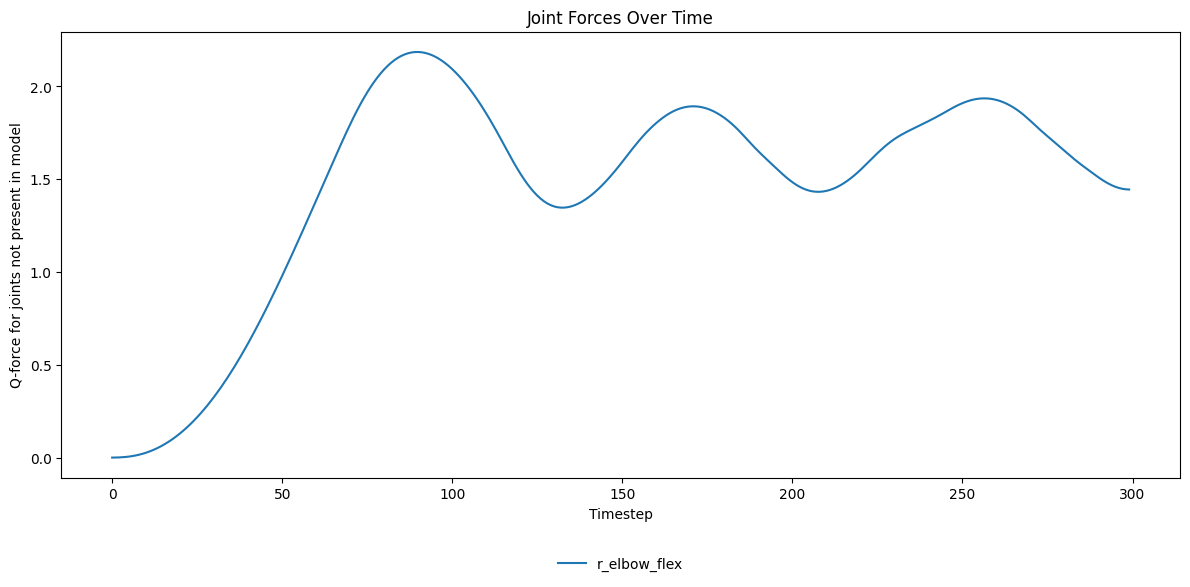

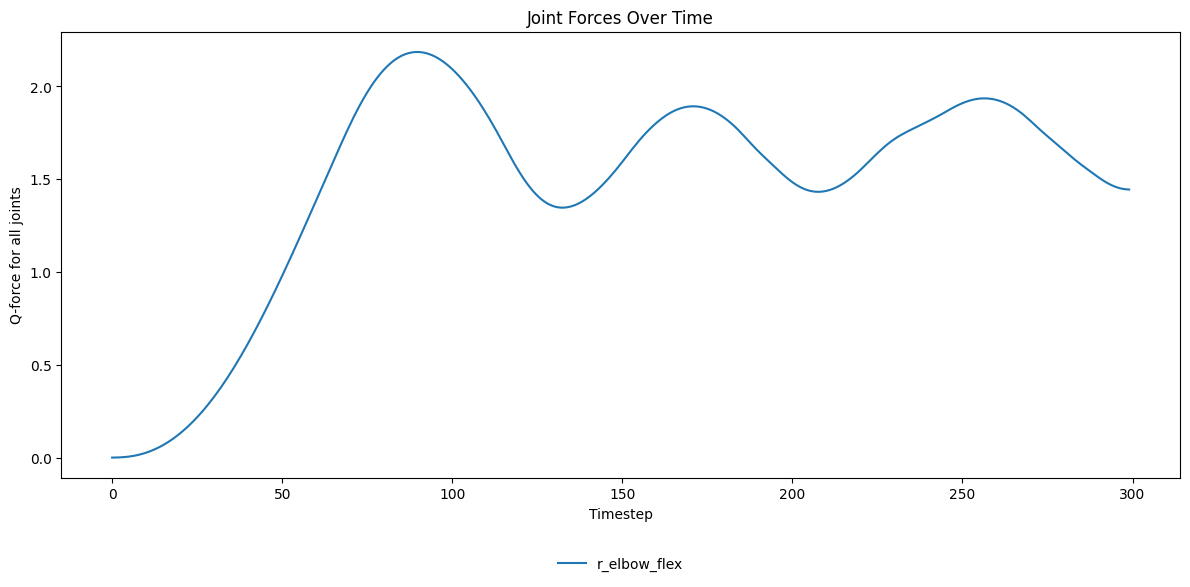

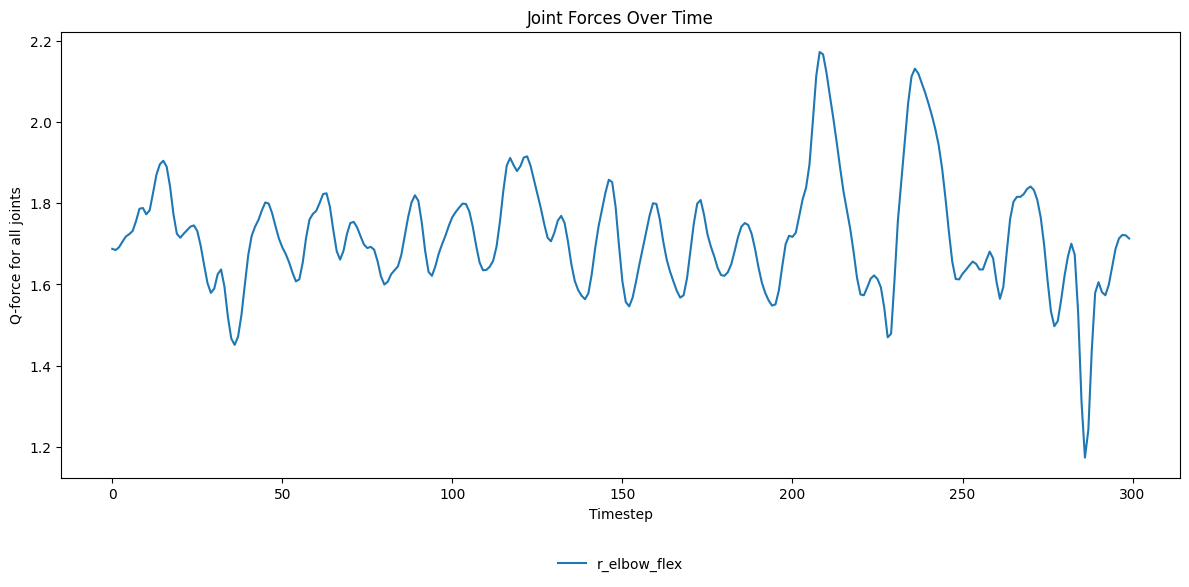

In [242]:
all_ctrl = np.zeros((qpos_ref.shape[0], 1+model1.nu)) # model.nu = number of actuators in the model
qpos_test = np.zeros((qpos_ref.shape[0], data1.qpos.shape[0]))
for idx in tqdm(range(qpos_ref.shape[0])):
    target_qpos = qpos_ref[idx, :]
    # qfrc = get_qfrc_differentiation(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx])
    qfrc = get_qfrc_posdifference(model1, data1, target_qpos)
    # data1.qfrc_applied = qfrc
    ctrl = get_ctrl(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx], qfrc, 10, 5)
    
    # Setting qpos and qvel nullified the control - hence remove them
    # data1.qpos = qpos_ref[idx]
    # data1.qvel = qvel_ref[idx]
    data1.ctrl = ctrl
    mujoco.mj_step(model1, data1)
    
    qpos_test[idx,:] = data1.qpos
    all_ctrl[idx,:] = np.hstack((data1.time, ctrl))
    
# Plot qforce
joint_names = [model1.joint(i).name for i in range(model1.njnt)]
plot_qforce(qforce=qpos_test, model=model1, not_present_joints=not_present_jnt_indexes)
plot_qforce(qforce=qpos_test, model=model1)
plot_qforce(qforce=qpos_ref, model=model1)

# Error metrics
error = ((qpos_test[:,:] - qpos_ref[:,:])**2).mean(axis=0)

print(f"Error(mean rads): {error.mean()}")

In [219]:
# Plot individual errors
jnt_error_map = map_error_to_joint(error, model1)
df = pd.DataFrame(list(jnt_error_map.items()), columns=["joint", "error"])
df.to_csv(f"{model_path.split('/')[-1].split('.')[0]}_jnt_error_map.csv", index=False)

# Render video - both test and reference model

In [220]:
import mujoco
import numpy as np
import os, skvideo.io
from tqdm import tqdm

# ---- load models
model_ref = mujoco.MjModel.from_xml_path(model_path)
model_ref.actuator_dynprm[:, 2] = tausmooth
data_ref = mujoco.MjData(model_ref)

model_test = mujoco.MjModel.from_xml_path(model_path)
model_test.actuator_dynprm[:, 2] = tausmooth
data_test = mujoco.MjData(model_test)

# ---- camera (front view)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.azimuth = 90       # 0=front, 90=left, 180=back, 270=right
camera.elevation = -10   # tilt downward
camera.distance = 2.0
camera.lookat[:] = [0, 0, 1]

# ---- visualization options
scene_option = mujoco.MjvOption()
mujoco.mjv_defaultOption(scene_option)

# ---- renderers (offscreen)
renderer_ref = mujoco.Renderer(model_ref, height=480, width=640)
renderer_test = mujoco.Renderer(model_test, height=480, width=640)

frames_ref, frames_test = [], []

# ---- reset test simulation to match reference start
# mujoco.mj_resetData(model_test, data_test)
# data_test.qpos[:] = qpos_ref[0]   # start same as reference
# data_test.qvel[:] = 0             # zero velocity
# mujoco.mj_forward(model_test, data_test)


# ---- generation loop
# act_force_norms = []
for idx in tqdm(range(qpos_ref.shape[0])):

    # --- Reference trajectory (direct playback)
    data_ref.qpos[:] = qpos_ref[idx]
    mujoco.mj_step1(model_ref, data_ref) # mj_step1: Only position dependent computations

    # --- Test trajectory (true simulation with controls)
    # data_test.qpos[:] = qpos_test[idx]
    ctrl_values = all_ctrl[idx, 1:]
    ctrl_values = np.nan_to_num(ctrl_values, nan=0.0, posinf=0.0, neginf=0.0)
    data_test.ctrl = ctrl_values  # apply controls    
    mujoco.mj_step(model_test, data_test)  # advance simulation
    
    # if not idx % round(0.3/(model_test.opt.timestep*25)):
    renderer_ref.update_scene(data_ref, camera=camera, scene_option=scene_option)
    frames_ref.append(renderer_ref.render())
    
    renderer_test.update_scene(data_test, camera=camera, scene_option=scene_option)
    frames_test.append(renderer_test.render())

# -----------------------------
# Diagnostics
# -----------------------------
# act_force_norms = np.array(act_force_norms)
# print(f"[DEBUG] qfrc_actuator norm: min={act_force_norms.min():.3e}, "
#       f"median={np.median(act_force_norms):.3e}, max={act_force_norms.max():.3e}")
# if np.allclose(act_force_norms, 0):
#     print("[WARNING] Actuator forces are ~zero for all steps. "
#           "Likely causes: wrong ctrl dimension/order, actuators disabled, "
#           "zero gains/gear, or controls outside actuator range and clamped.")


# ---- save videos
outdir = "/Users/siddheshkanawade/Desktop/Siddhesh/Projects/myosuite-table-tennis/content/videos"
os.makedirs(outdir, exist_ok=True)

skvideo.io.vwrite(os.path.join(outdir, f"{model_path.split('/')[-1].split('.')[0]}_ref.mp4"),
                  np.asarray(frames_ref),
                  outputdict={"-pix_fmt": "yuv420p"})

skvideo.io.vwrite(os.path.join(outdir, f"{model_path.split('/')[-1].split('.')[0]}_test.mp4"),
                  np.asarray(frames_test),
                  outputdict={"-pix_fmt": "yuv420p"})

print("Videos saved successfully.")


100%|██████████| 300/300 [00:16<00:00, 17.77it/s]


Videos saved successfully.
